In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'
raw = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')
raw = raw.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
## -------------------------------------------------- ##
raw['pitchID'] = np.where(raw['pitchID']=='-1', np.nan, raw['pitchID'])
raw['pitchID'] = raw['pitchID'].ffill()
## -------------------------------------------------- ##
rawdate = pd.DataFrame(raw['pitchID'])
raw['game_date_new'] = rawdate.applymap(str).applymap(lambda s: '20{}-{}-{} {}:{}:{}'.format(s[0:2],s[2:4],s[4:6], s[7:9],s[9:11],s[11:13]))
## -------------------------------------------------- ##
df = raw.copy()
df = df.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
## -------------------------------------------------- ##
df['throws_stands'] = df['throws']+'_'+df['stands']
df['throws_stands_le']= df['throws_stands'].replace({'우_우':'1', '우_좌':'2', '좌_우':'3', '좌_좌':'4'}, regex=True)

def one_digit(n): return f"{n:.0f}"
def two_digit(n): return f"{n:02d}"
def three_digit(n): return f"{n:03d}"
def six_digit(n): return f"{n:06d}"
df['zone101_new']=df['zone101_new'].apply(two_digit)
df['bs_cnt']=df['bs_cnt'].apply(two_digit)
df['bso_cnt']=df['bso_cnt'].apply(three_digit)
df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)

c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [84]:
events_df = df[["game_date_new", "gid", "gid-intot-panum", "gid-intot-panum-pitnum"
                , "cid", "pid", "bid","p_team", "b_team", "throws", "stands", "px", "pz"
                , "pitch_type", 'pitch_type_le', "pitch_class", 'pitch_class_le'
                , "pitch_result", "pa_result", "pa_result_en",'pa_cate_en1','pa_cate_en2','pa_cate_en3'
                , "b", "s", "o", "1b", "2b", "3b", "p_score", "b_score", "bs_cnt", "bso_rcnt", "diff_score", "pitchID"
                , "pitch_number", "pa_number"]].copy()

pit_len = events_df.groupby(["gid-intot-panum"]).agg(pit_len=("pitch_number","last")).reset_index()
events_df = pd.merge(events_df, pit_len, on='gid-intot-panum', how='left')

events_df['pitch_type_next_le']= events_df.groupby(["gid-intot-panum"])[["pitch_type_le"]].shift(-1)
events_df['px_next']= events_df.groupby(["gid-intot-panum"])[["px"]].shift(-1)
events_df['pz_next']= events_df.groupby(["gid-intot-panum"])[["pz"]].shift(-1)
events_df.shape
## -------------------------------------------------- ##
events_df[['pa_result',"pa_result_en", 'pa_cate_en1','pa_cate_en2','pa_cate_en3']] =\
events_df[['pa_result',"pa_result_en", 'pa_cate_en1','pa_cate_en2','pa_cate_en3']].bfill()

In [85]:
events_df["pa_result"].value_counts() #297109

삼진              295994
필드 아웃           262761
포스 아웃           241990
안타              177687
볼넷              165733
2루타              48180
홈런               25928
병살타              21449
내야안타             19812
몸에 맞는 볼          14836
실책               10773
희생플라이             8993
희생번트              5254
3루타               4045
번트 안타             1385
낫아웃 출루            1104
자동 고의4구            988
야수 선택              818
고의4구               751
삼중살                 29
타구맞음 아웃             23
낫아웃 다른 주자 수비        11
Name: pa_result, dtype: int64

In [86]:
events_df.groupby(["pitch_type_le", "pitch_type"])[["pitch_number"]].count().reset_index().T

,0,1,2,3,4,5,6,7,8
pitch_type_le,1,2,3,4,5,6,7,8,9
pitch_type,너클,슬라,싱커,직구,체인,커브,커터,투심,포크
pitch_number,1219,242466,170,587498,134713,125151,31749,100657,84921


In [87]:
test = events_df[(events_df["pa_result"] == "삼진")&(pd.isnull(events_df["pitch_type_next_le"])==False)]\
[["gid-intot-panum-pitnum", 'cid', 'pit_len', "pitch_type", "pitch_type_le", 'pitch_type_next_le', 'px','pz', 'px_next','pz_next']]
test.index = test['gid-intot-panum-pitnum']
test = test.drop(columns=['gid-intot-panum-pitnum'])
test['pitch_type_next_le'] = test['pitch_type_next_le'].astype(int)
test[['px','pz','px_next','pz_next']] = test[['px','pz','px_next','pz_next']].fillna(test[['px','pz','px_next','pz_next']].median())
# 4574/235281*100
test

,cid,pit_len,pitch_type,pitch_type_le,pitch_type_next_le,px,pz,px_next,pz_next
gid-intot-panum-pitnum,,,,,,,,,
20170331HHOB02017-019-05-01,조인성-98144,6,직구,4,6,0.929,0.888,-1.352,3.092
20170331HHOB02017-019-05-02,조인성-98144,6,커브,6,4,-1.352,3.092,-0.117,2.912
20170331HHOB02017-019-05-03,조인성-98144,6,직구,4,5,-0.117,2.912,-0.477,1.404
20170331HHOB02017-019-05-04,조인성-98144,6,체인,5,4,-0.477,1.404,-0.310,3.614
20170331HHOB02017-019-05-05,조인성-98144,6,직구,4,2,-0.310,3.614,0.946,2.715
...,...,...,...,...,...,...,...,...,...
20221011KTLG02022-089-68-01,장성우-78548,3,슬라,2,2,-0.211,1.798,-0.636,2.977
20221011KTLG02022-089-68-02,장성우-78548,3,슬라,2,4,-0.636,2.977,-0.688,2.899
20221011KTLG02022-099-77-01,장성우-78548,4,직구,4,4,-0.220,2.290,-0.491,2.768


---
## 2. clustering

### 2.1 Preparing data

In [110]:
x1 = test["px"]; x2 = test["px_next"]
y1 = test["pz"]; y2 = test["pz_next"]
test["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
test["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
league_df = test.copy()
league_df # 235,281

,cid,pit_len,pitch_type,pitch_type_le,pitch_type_next_le,px,pz,px_next,pz_next,length,angle
gid-intot-panum-pitnum,,,,,,,,,,,
20170331HHOB02017-019-05-01,조인성-98144,6,직구,4,6,0.929,0.888,-1.352,3.092,3.171841,-0.802565
20170331HHOB02017-019-05-02,조인성-98144,6,커브,6,4,-1.352,3.092,-0.117,2.912,1.248048,1.715526
20170331HHOB02017-019-05-03,조인성-98144,6,직구,4,5,-0.117,2.912,-0.477,1.404,1.550375,-2.907252
20170331HHOB02017-019-05-04,조인성-98144,6,체인,5,4,-0.477,1.404,-0.310,3.614,2.216301,0.075422
20170331HHOB02017-019-05-05,조인성-98144,6,직구,4,2,-0.310,3.614,0.946,2.715,1.544583,2.192024
...,...,...,...,...,...,...,...,...,...,...,...
20221011KTLG02022-089-68-01,장성우-78548,3,슬라,2,2,-0.211,1.798,-0.636,2.977,1.253262,-0.345976
20221011KTLG02022-089-68-02,장성우-78548,3,슬라,2,4,-0.636,2.977,-0.688,2.899,0.093744,-2.553590
20221011KTLG02022-099-77-01,장성우-78548,4,직구,4,4,-0.220,2.290,-0.491,2.768,0.549477,-0.515760


In [102]:
cols = ["pit_len", "pitch_type_le", "pitch_type_next_le", "px", "pz", "px_next", "pz_next"]
ss = StandardScaler()
league_df_transformed = ss.fit_transform(league_df[cols])
league_df_transformed

array([[ 0.39149434, -0.30825194,  0.66146967, ..., -1.49348519,
        -1.58755232,  0.83561018],
       [ 0.39149434,  0.69685948, -0.31314439, ...,  0.76360892,
        -0.18647582,  0.65355038],
       [ 0.39149434, -0.30825194,  0.17416264, ...,  0.57927274,
        -0.59488678, -0.87170615],
       ...,
       [-0.90742871, -0.30825194, -0.31314439, ..., -0.05771117,
        -0.61076943,  0.50790254],
       [-0.90742871, -0.30825194, -0.31314439, ...,  0.4318038 ,
        -0.35437811,  1.46068215],
       [-0.90742871, -0.30825194, -0.31314439, ...,  1.39649647,
         0.06424313,  1.77321813]])

### 2.2 Cluster with Mini-batch Kmeans

In [103]:
n_cluster = 400 #547,887
kmeans = MiniBatchKMeans(n_clusters=n_cluster, batch_size=5000, n_init=10)
kmeans.fit_predict(league_df_transformed);

In [104]:
league_df["cluster"] = kmeans.labels_+1

In [107]:
def plot_clusters(clustered_df, n_clusters):
    f1 = plt.figure(figsize=(20,70))
    f1.subplots_adjust(hspace=0.6)
    
    cmap = cm.get_cmap('jet')
    n_passes_plot = 10
    
    for cluster in range(1,n_clusters+1):
    
        plt.subplot(50, 8, cluster)

    
        for index in clustered_df[clustered_df["cluster"]==cluster].head(n_passes_plot).index:
        
            x_val =  clustered_df.loc[index]["px"] 
            y_val =  clustered_df.loc[index]["pz"] 
            dx_val = clustered_df.loc[index]["px_next"]
            dy_val = clustered_df.loc[index]["pz_next"]
           
            plt.arrow(
                x= x_val, 
                y= y_val, 
                dx = dx_val,
                dy = dy_val,
                head_width=0.5, 
                head_length=0.5)
        
        plt.xlim(-4,4)
        plt.ylim(-3,8)
        plt.title(cluster)

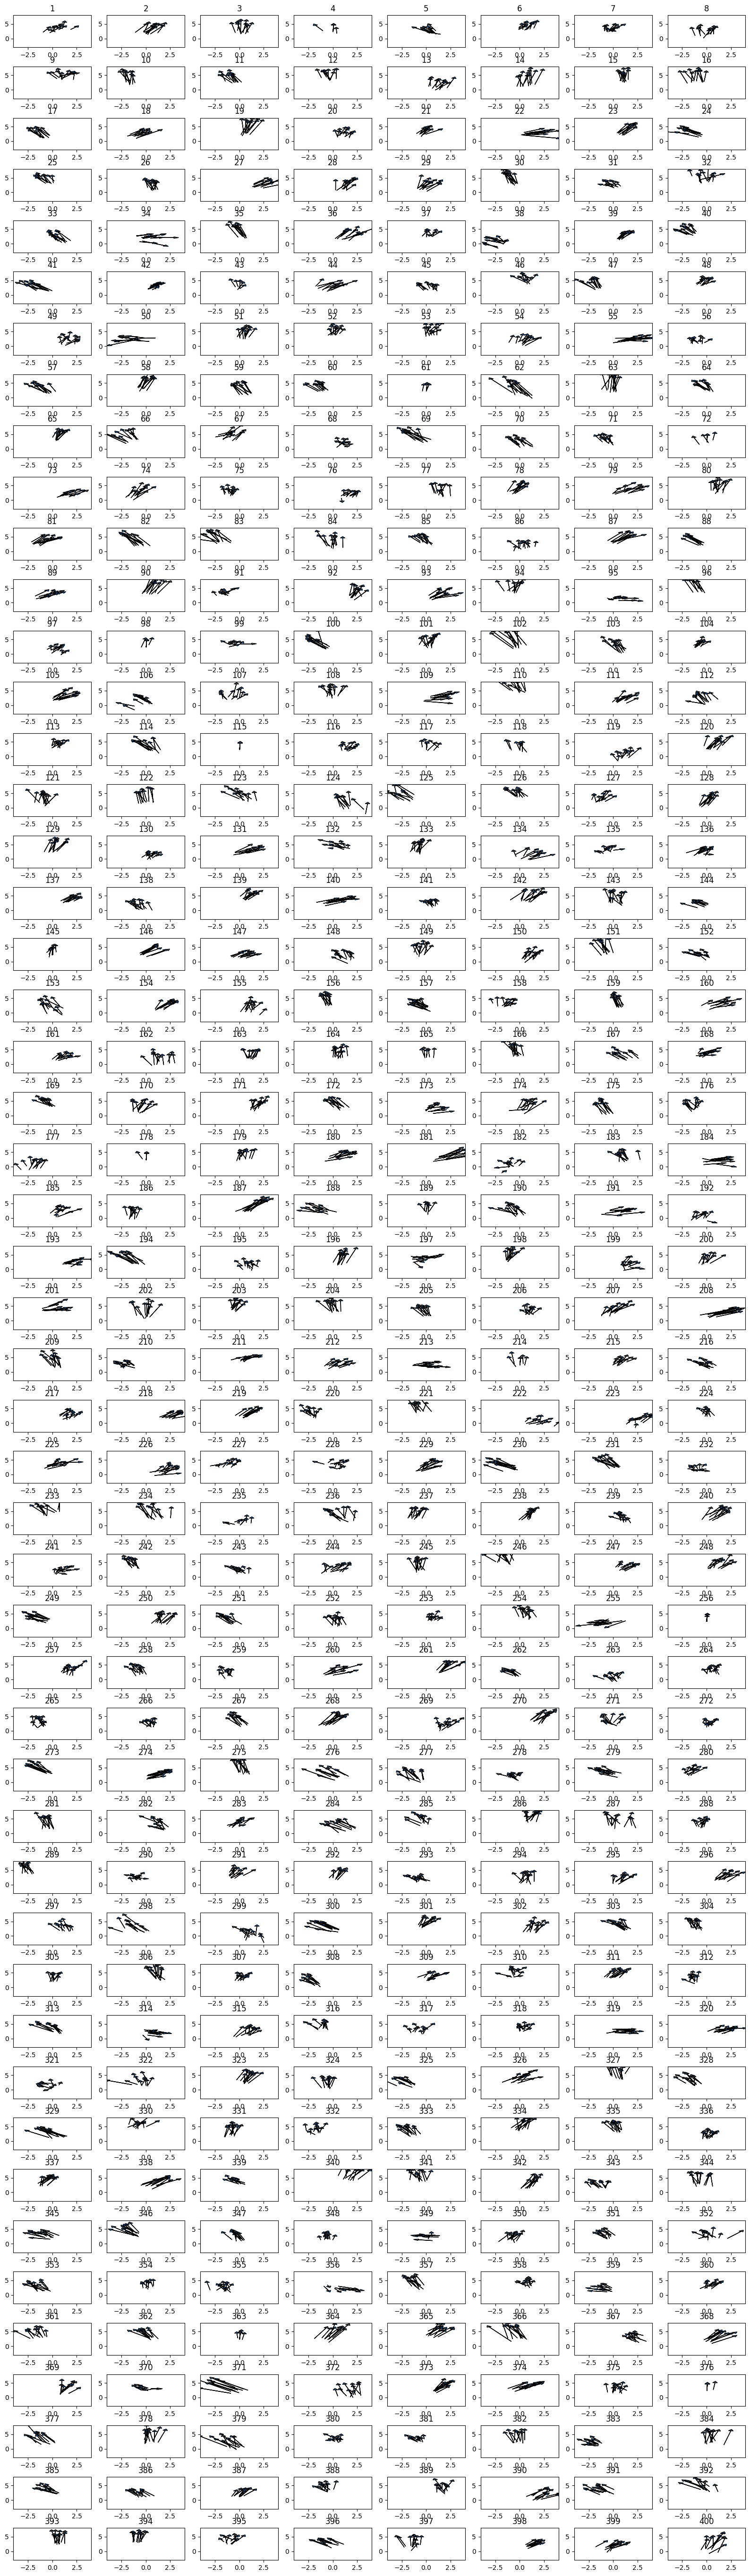

In [108]:
plot_clusters(league_df, n_clusters=400)

# # plot cluster centers
# for i, coords in enumerate(ss.inverse_transform(kmeans.cluster_centers_)):
#     ax[i].arrow(pass_coords[3], pass_coords[4], coords[5], pass_coords[6],
#                 head_width=2, linewidth=2, color="red")